# Sentiment Analysis of US Presidential Elections 2020

Author: Lydia Jeong <br>
November 25, 2020

Sentiment Analysis is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”.
Sentiment analysis is a technology of increasing importance in the modern society as it allows
individuals and organizations to detect trends in public opinion by analyzing social media
content. Keeping abreast of socio-political developments is especially important during periods
of policy shifts such as election years, when both electoral candidates and companies can benefit
from sentiment analysis by making appropriate changes to their campaigning and business
strategies respectively.
The purpose of this assignment is to compute the sentiment of text information - in our case, tweets posted recently on US Presidential Elections 2020 - and answer the research question: ***“What can public opinion on Twitter tell us about the US political landscape in 2020?”*** The goal is to essentially use sentiment analysis on Twitter data to get insight into the 2020 American Elections.

Two datasets are used in this project. The sentiment_analysis.csv file contains generic tweets that includes the following columns. The Sentiment has already been analyzed and indicated in the "sentiment" column. <br>

|   | column | description                                         |
|---|-------|-----------------------------------------------------------------------------|
| 0 | ID    | Tweet ID                                                                    |
| 1 | text  | the text of the tweet                                                       |
| 2 | label | the polarity of each tweet (0 = negative sentiment, 1 = positive sentiment) |

US_Elections_2020.csv is a dataset that contains tweet data about the 2020 US Presidential elections. It includes the following features: <br>

|   | column          | description                                         |
|---|-----------------|-----------------------------------------------------|
| 0 | text            | the text of the tweet                               |
| 1 | sentiment       | 1 for positive sentiment, 0 for negative sentiment  |
| 2 | negative_reason | reason for negative tweets. NaN for positive tweets |

#### Install and import required libraries

In [ ]:
!pip install nltk

In [ ]:
!pip install wordcloud

In [ ]:
!pip install xgboost

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import html
import string
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize.treebank import TreebankWordDetokenizer
from html.parser import HTMLParser
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from numpy import array
from scipy.sparse import csr_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1) Data cleaning

#### Read the csv files.

In [69]:
# read both csv files.
df_sent_analysis = pd.read_csv('sentiment_analysis.csv')
df_elections = pd.read_csv('US_Elections_2020.csv')

In [70]:
# display the first 5 rows of df_sent_analysis
df_sent_analysis.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [71]:
# display the first 5 rows of df_elections
df_elections.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


#### Check that there are no missing values

It is important that there are no missing values especially in the 'label' or 'sentiment' column. Therefore, I will use the dropna() function. Whether or not missing value exists in the dataset, it is essential to check.

In [72]:
# Drop any missing values if it exists in the 'label' or 'sentiment' column.
df_sent_analysis.label.dropna(inplace=True)
df_elections.sentiment.dropna(inplace=True)

#### Clean the tweets

Since the tweets have too much noise, they must be processed and cleaned to prepare for analysis. Below are the steps I took to cleaning the text:
1. Remove all URLs.
2. Remove all html tags attributes using RegEx.
3. Replace html character codes (i.e., &...;) with an ASCII equivalent.
4. Remove emojis, symbols, and pictures.
5. Convert all characters in the text to lowercase.
6. Remove all punctuations.
7. Remove stop words.

In [73]:
# extract the text column in the dataset and convert it into a list containing all the tweets.
sent_tweets = df_sent_analysis.text.tolist()
election_tweets = df_elections.text.tolist()

# display the first 10 tweets
sent_tweets[:10]

['Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0',
 'RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…',
 'RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…',
 'RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer.  Great job ladies!!!#EC_proud https://t.co/…',
 'RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3',
 'RT @SH4WNSMILE: -Who is excited for illuminate !? -.... https://t.co/AKnIVEGUOe',
 'RT @KendallHuntRPD: The #firstdayofschool for students &amp; teachers. Good luck and have a Successful 2016-17 School Year #EducationMatters ht…',
 'RT @BantySrkian: #SRK and kajol in the making of DDLJ song .. Both are greate

Below, I defined the function to clean the tweets.
For stop words, it is important to note that I did not consider words such as "no", "not", and "wasn't" as stop words because these words could be important for sentiment analysis. The absence of these words may incorrectly influence the sentiment of the text. Therefore, they were removed from the stop word list provided by NLTK.

In [74]:
def clean_tweets(tweet):    
    # All URLs are removed
    cleanr = re.compile('(http|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
    tweet = re.sub(cleanr, '', tweet)
    
    # All html tags attributes are removed using RegEx.
    tweet = re.sub(r'/<[^<]+?>/', ' ', tweet)
    
    #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    htmlparser = HTMLParser()
    tweet = htmlparser.unescape(tweet)

    # remove Emojis, symbols, pictures, etc.
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
                               "]+", flags = re.UNICODE)
    tweet = regrex_pattern.sub(r'',tweet)
    
    # All characters in the text are in lowercase.
    tweet = tweet.lower()
    
    #remove all punctuations    
    tweet=tweet.translate(str.maketrans("","",string.punctuation))
    tweet=tweet.translate(str.maketrans("","",string.digits))
    
    # Remove stop words. First, modify the stop words list by removing the negation words.
    to_remove = ['no', 'nor', 'not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'isn', "isn't", 'wasn', "wasn't", 'weren', "weren't",
                "won't", 'wouldn', "wouldn't"]
    stop_words = set(stopwords.words('english')).difference(to_remove) # remove the negation words from the stop words list.
   
    to_add = {'rt', 'h', 'ht','htt','http','https','https:','https://', '…'}
    stop_words = stop_words.union(to_add)  # include other unimport characters in the stop words list.
    
    word_tokens = word_tokenize(tweet) # tokenize the tweets
    filtered_sentence = [w for w in word_tokens if w not in stop_words] # filter the sentence to remove stop words.
    
    return filtered_sentence

In [75]:
# clean both generic and elections tweets
cleaned_sent_tweets = []
for tw in sent_tweets:
    cleaned_sent_tweets.append(clean_tweets(tw))

cleaned_election_tweets = []
for tw in election_tweets:
    cleaned_election_tweets.append(clean_tweets(tw))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  # This is added back by InteractiveShellApp.init_path()


In [76]:
# add the cleaned tweets as a new column to the dataset and drop the original text column
df_sent_analysis['cleaned_tweet_tokenized'] = cleaned_sent_tweets
df_sent_analysis.drop(columns='text', inplace=True)

df_elections['cleaned_tweet_tokenized'] = cleaned_election_tweets
df_elections.drop(columns='text', inplace=True)

In [77]:
# add a column 'cleaned_tweet' that has the detokenized texts. This will be used later for the analysis part.
detokenize_sent_analysis = []
for tweet in df_sent_analysis['cleaned_tweet_tokenized']:
    detokenize_sent_analysis.append(TreebankWordDetokenizer().detokenize(tweet))
df_sent_analysis['cleaned_tweet'] = detokenize_sent_analysis
    
detokenize_elections = []
for tweet in df_elections['cleaned_tweet_tokenized']:
    detokenize_elections.append(TreebankWordDetokenizer().detokenize(tweet))
df_elections['cleaned_tweet'] = detokenize_elections

In [79]:
# Drop any irrelevant columns for our analysis.
df_sent_analysis.drop(columns=['ID', 'cleaned_tweet_tokenized'], inplace=True)

#display the first 5 rows of the dataset
df_sent_analysis.head()

,label,cleaned_tweet
0,1,josh jenkins looking forward tab breeders crow...
1,1,mianusmanjaved congratulations pakistan becomi...
2,1,pepalerts september yesmag taking maine mendoz...
3,1,davidgaibis newly painted walls thanks million...
4,1,cedricfeschotte excited announce july feschott...


## **2) Exploratory analysis**

For the next step, I determined the political party (Republican party, Democratic Party, and Others) of a given tweet for the 2020 elections dataset. Procedure I used was to find relevant words in the tweets that identify to certain political parties and created three new columns (one for each party). If a sentiment of that party was positive, it was assigned as "positive" in that column. If the sentiment was negative, it was assigned as "negative".

#### Determine the political party of a given tweet

In [80]:
def determine_political_party(df):
    
    # Relevant words in the tweets that identify to certain political parties or candidates
    republican = '.*republican.*|.*republicans.*|.*donald trump.*|.*donaldtrump.*|.*donald.*|.*trump.*|.*republican party.*' 
    democratic = '.*democratic.*|.*democrats.*|.*joe biden.*|.*joebiden.*|.*joe.*|.*biden.*|.*democratic party.*' 
    
    # Create three new columns: Republican, Democratic, and Others
    df['Republican'] = ''
    df['Democratic'] = ''
    df['Others'] = ''
    
    for i in df.index:
        if re.match (republican, df['cleaned_tweet'][i]) :
            if df['sentiment'][i] == 1: # if the sentiment is positive, i.e. 1, add 'positive'
                df["Republican"][i] = 'positive'
            else :
                df["Republican"][i] = 'negative' # if the sentiment is negative, i.e. 0, add 'negative'
                
        if re.match (democratic, df['cleaned_tweet'][i]) :
            if df['sentiment'][i] == 1: # if the sentiment is positive, i.e. 1, add 'positive'
                df["Democratic"][i] = 'positive' 
            else :
                df["Democratic"][i] = 'negative' # if the sentiment is negative, i.e. 0, add 'negative'
                
        if df["Republican"][i] == '' and df["Democratic"][i] == '':
            if df['sentiment'][i] == 1: # if the sentiment is positive, i.e. 1, add 'positive'
                df["Others"][i] = 'positive'
            else :
                df["Others"][i] = 'negative' # if the sentiment is negative, i.e. 0, add 'negative'

In [81]:
# Apply this function to the 2020 US elections dataset.
determine_political_party(df_elections)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: Settin

In [82]:
# Show the new elections dataset
df_elections.head()

,sentiment,negative_reason,cleaned_tweet_tokenized,cleaned_tweet,Republican,Democratic,Others
0,0,covid19,"[brobreiner, afraid, nov, dec, jan, even, bide...",brobreiner afraid nov dec jan even bidenharris...,,negative,
1,0,others,"[brt, sueck, lord, sumption, launches, recover...",brt sueck lord sumption launches recovery new ...,,,negative
2,0,covid19,"[brt, walidphares, uber, timing, biden, adviso...",brt walidphares uber timing biden advisors sai...,,negative,
3,1,NaN,"[bevery, seconds, american, dying, trumpvirus,...",bevery seconds american dying trumpvirus nndon...,positive,positive,
4,1,NaN,"[brt, thewebbix, democrats, embrace, diversity...",brt thewebbix democrats embrace diversityandin...,,positive,


In [83]:
# Separate the dataset into positive and negative for each parties. These variables will also be used later in the analysis
republican_positive = df_elections[df_elections.Republican == 'positive']
democratic_positive = df_elections[df_elections.Democratic == 'positive']
republican_negative = df_elections[df_elections.Republican == 'negative']
democratic_negative = df_elections[df_elections.Democratic == 'negative']

# Print the number of positive and negative sentiments of each party.
print("Positive sentiments about the Republican party: ", republican_positive.Republican.count())
print("Negative sentiment about the Republican party: ", republican_negative.Republican.count())
print("Positive sentiment about the Democratic party: ", democratic_positive.Democratic.count())
print("Negative sentiment about the Democratic party: ", democratic_negative.Democratic.count())

Positive sentiments about the Republican party:  408
Negative sentiment about the Republican party:  501
Positive sentiment about the Democratic party:  447
Negative sentiment about the Democratic party:  335


#### Ploting a bar graph to visualize the distribution of the political affiliations of the tweets

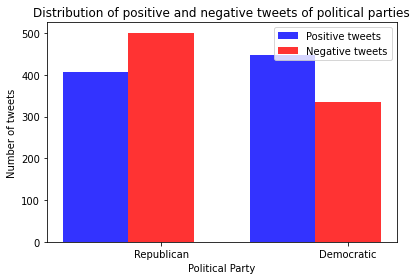

In [84]:
# Data to plot
n_groups = 2
positive = (408, 447) # (number of positive Republican tweets, number of positive Democratic tweets)
negative = (501, 335) # (number of negative Republican tweets, number of negative democratic tweets)

# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

bar1 = plt.bar(index, positive, bar_width, alpha=opacity, color='b', label='Positive tweets')
bar2 = plt.bar(index + bar_width, negative, bar_width, alpha=opacity, color='r', label='Negative tweets')

plt.xlabel('Political Party')
plt.ylabel('Number of tweets')
plt.title('Distribution of positive and negative tweets of political parties')
plt.xticks(index + bar_width, ('Republican', 'Democratic'))
plt.legend()

plt.tight_layout()
plt.show()

Based on the bar plots above, it appears that more people feel negatively about the Republican party compared to the Democratic party, as evidenced in their greater number of negative tweets. There are slightly higher positive tweets about the Democratic party than Republican, so perhaps it can be assumed that Democratic party have more positive affiliations.

#### Visualizing some aspect of the generic tweets using Word Cloud

Word cloud was generated that could give some insight into the most common topics that people are talking about.

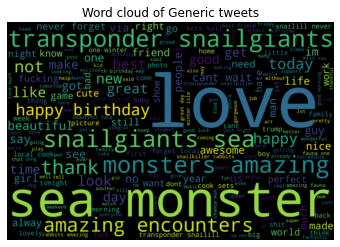

In [86]:
# combine all the tweets into one string
combined_sent = ''
for tweet in df_sent_analysis['cleaned_tweet']:
    combined_sent = combined_sent + '' + tweet
    
# Generate the word cloud
cloud_sent = WordCloud(width=3000, height=2000, stopwords={'ht', 'htt', 'http', 'https', 'httpst'}).generate(combined_sent)

# Display the word cloud
plt.imshow(cloud_sent, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of Generic tweets')
plt.show()

As illustrated on the word cloud figure, it seems that there are many positive sentiments in the generic tweets. Words such as "love", "amazing", "thank", "happy", "birthday" stand out in the word cloud. Other words, such as "monster", "sea", and "snailgiants" also seem prominant, which may or may not be neutral. However, definitely positive words appear in the figure. This figure confirms that there are more positive sentiments compared to negative, as shown on the value_counts() output. There are 371341 positive tweets compared to 179050 negative tweets.

In [87]:
df_sent_analysis.label.value_counts()

1    371341
0    179050
Name: label, dtype: int64

#### Visualizing some aspect of the 2020 US Election tweets using Word Cloud

I have also created a word cloud for the 2020 US Election tweets to understand the most important issues during the election period.

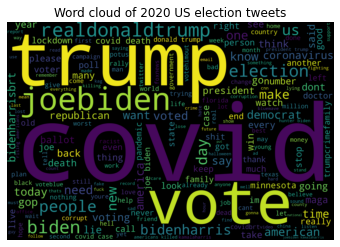

In [44]:
# combine all the tweets into one string
combined_election = ''
for tweet in df_elections['cleaned_tweet']:
    combined_election = combined_election + '' + tweet

# Generate the word cloud
cloud_election = WordCloud(width=3000, height=2000).generate(combined_election)

# Display the word cloud
plt.imshow(cloud_election, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of 2020 US election tweets')
plt.show()

Looking at the word cloud of 2020 US election tweets, words such as Trump, Covid, and Vote stand out the most. From this figure, it can be deduced that Covid-19 is one of the top issues facing the country during the elections period.

### Visualizing negative sentiment reasons of each party

In [ ]:
# Split the negative tweets data into two parties
republican_negative = df_negative[df_negative.Republican == 'Yes']
democratic_negative = df_negative[df_negative.Democratic == 'Yes']

In [ ]:
print(republican_negative.negative_reason.value_counts())

covid19           159
discrimination     97
corruption         89
crime              85
others             71
Name: negative_reason, dtype: int64


In [ ]:
democratic_negative.negative_reason.value_counts()

covid19           105
others             64
corruption         62
crime              58
discrimination     46
Name: negative_reason, dtype: int64

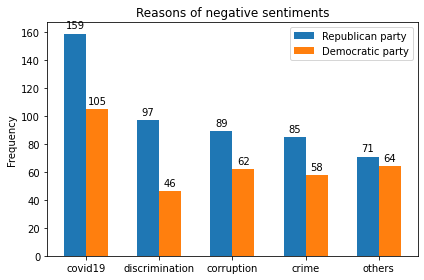

In [ ]:
labels = ['covid19', 'discrimination', 'corruption', 'crime', 'others']
republican = [159, 97, 89, 85, 71]
democratic = [105, 46, 62, 58, 64]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
r = ax.bar(x - width/2, republican, width, label='Republican party')
d = ax.bar(x + width/2, democratic, width, label='Democratic party')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Reasons of negative sentiments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(r)
autolabel(d)
fig.tight_layout()
plt.show()

As indicated on the plot, there are many negative tweets towards the Republican party relating to Covid-19. As Covid-19 has been one of the major issues we are facing today, it makes sense that we see such a high number of negative tweets about this subject. What is interesting to note is that the majority of Covid-19 negative tweets are concerned with the Republican party. Negative tweets about the Democratic party is smaller than Republican party for all five reasons.

## 3) Model preparation

Next, I used Bag of Words (BoW) and TF-IDF features to prepare the data for multiple classification algorithms: Logistic Regression, k-NN, Naive Bayes, SVM, decision trees, Random Forests, and XGBoost. The target variable was the sentiment (positive or negative). After creating BoW and TF-IDF, I split the generic tweets randomly into training and testing data (70/30 split respectively).

In [88]:
# Check the number of samples for the sentiment analysis data
df_sent_analysis.shape[0]

550391

Note: Using about 500,000 samples to analyze data caused extremely slow time for me when running the cells, therefore, to solve this issue, I randomly selected a subset of samples to be reduced to 100,000.

In [89]:
# Reduce the sample size to 100,000
df_sent_analysis = df_sent_analysis.sample(n=100000)

### Create Bag of Words features

I set maximum features to be 3000 and the number of n-grams to be unigrams, bigrams, and trigrams. Since unigrams have a risk of ignoring the context (i.e. not considering negation words) and trigrams have a risk of overfitting, using variety of them can be a good balance.

In [90]:
# Create Bag of Words.
vect_bow = CountVectorizer(max_features=3000, ngram_range=(1, 3), stop_words={'ht', 'htt', 'http', 'https', 'httpst'})
vect_bow.fit(df_sent_analysis.cleaned_tweet)
X_bow = vect_bow.transform(df_sent_analysis.cleaned_tweet)

# Transform back to a dataframe, assign column names
X_bow = pd.DataFrame(X_bow.toarray(), columns=vect_bow.get_feature_names())

# Display first 5 rows of the dataframe
X_bow.head()

,able,absolute,absolutely,abt,abuse,accept,accident,account,accurate,accused,achievement,across,act,acting,action,actor,actress,actual,actually,ad,add,added,adopt,adorable,adrianrietveld,adrianrietveld amazing,adrianrietveld amazing custom,adult,adventure,advice,af,affordable,afraid,africa,african,african fifa,african fifa world,afternoon,age,ago,...,xbox,xd,xmas,xo,xx,xxx,ya,yall,yay,yeah,year,year old,yearold,years,years ago,years old,yemen,yes,yesterday,yet,yo,yoga,york,you,youd,youll,youll love,young,youre,youre not,youth,youtube,youve,yr,yrs,yummy,zombie,zombie discover,zombie discover die,zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
# convert to sparse matrix
X_bow = csr_matrix(X_bow)

In [92]:
# Train test split and prepare the data for multiple classification algorithms for BOW
y_b = df_sent_analysis.label
X_b = X_bow

# Train/test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=42)

### Create TF-IDF features

In [93]:
# Create TF-IDF
vect_tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 3), stop_words={'ht', 'htt', 'http', 'https', 'httpst'})
vect_tfidf.fit(df_sent_analysis.cleaned_tweet)
X_tfidf = vect_tfidf.transform(df_sent_analysis.cleaned_tweet)

# Create a DataFrame
X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vect_tfidf.get_feature_names())

# Display first 5 rows of the dataframe
X_tfidf.head()

,able,absolute,absolutely,abt,abuse,accept,accident,account,accurate,accused,achievement,across,act,acting,action,actor,actress,actual,actually,ad,add,added,adopt,adorable,adrianrietveld,adrianrietveld amazing,adrianrietveld amazing custom,adult,adventure,advice,af,affordable,afraid,africa,african,african fifa,african fifa world,afternoon,age,ago,...,xbox,xd,xmas,xo,xx,xxx,ya,yall,yay,yeah,year,year old,yearold,years,years ago,years old,yemen,yes,yesterday,yet,yo,yoga,york,you,youd,youll,youll love,young,youre,youre not,youth,youtube,youve,yr,yrs,yummy,zombie,zombie discover,zombie discover die,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# convert to sparse matrix
X_tfidf = csr_matrix(X_tfidf)

In [95]:
# Split the tweets randomly into 70% training and 30% test data for TF-IDF.
y_t = df_sent_analysis.label
X_t = X_tfidf

# Train/test split
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.3, random_state=42)

### Preparing data for multiple classification algorithms and comparing their accuracy scores

I ran all seven models for BoW and TF-IDF (14 models in total) and compared their accuracies. The best model was Logistic Regression with an accuracy of 0.954 for BoW method. The accurcy is very good, therefore, it is not necessary to perform hyperparameter tuning in this case.

#### Accuracy values for **BOW**

In [96]:
# Logistic Regression accuracy
model = LogisticRegression(max_iter=1000000).fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + LogisticRegression().__class__.__name__, ': ', accuracy)

Accuracy of LogisticRegression :  0.9539666666666666


In [97]:
# KNN accuracy
model = KNeighborsClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + KNeighborsClassifier().__class__.__name__, ': ', accuracy)

Accuracy of KNeighborsClassifier :  0.9038


In [98]:
# Naive Bayes accuracy
# Note: dense data is required since sparce matrix gave me an error. Used X.toarray() to convert to a dense numpy array.
model = GaussianNB().fit(X_train_b.toarray(), y_train_b)
y_predicted = model.predict(X_test_b.toarray())
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + GaussianNB().__class__.__name__, ': ', accuracy)

Accuracy of GaussianNB :  0.6795


In [99]:
# SVM accuracy
model = LinearSVC(max_iter=1000000).fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + LinearSVC().__class__.__name__, ': ', accuracy)

Accuracy of LinearSVC :  0.9518666666666666


In [100]:
# Decision tree accuracy
model = DecisionTreeClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + DecisionTreeClassifier().__class__.__name__, ': ', accuracy)

Accuracy of DecisionTreeClassifier :  0.9166666666666666


In [101]:
# Random Forest accuracy
model = RandomForestClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + RandomForestClassifier().__class__.__name__, ': ', accuracy)

Accuracy of RandomForestClassifier :  0.9358666666666666


In [102]:
# XGBoost accuracy
model = xgboost.XGBClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + xgboost.XGBClassifier().__class__.__name__, ': ', accuracy)

Accuracy of XGBClassifier :  0.7800666666666667


#### Accuracy values for **TF-IDF**

In [103]:
model = LogisticRegression(max_iter=1000000).fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + LogisticRegression().__class__.__name__, ': ', accuracy)

Accuracy of LogisticRegression :  0.9521666666666667


In [104]:
model = KNeighborsClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + KNeighborsClassifier().__class__.__name__, ': ', accuracy)

Accuracy of KNeighborsClassifier :  0.7822333333333333


In [105]:
# A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
model = GaussianNB().fit(X_train_t.toarray(), y_train_t)
y_predicted = model.predict(X_test_t.toarray())
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + GaussianNB().__class__.__name__, ': ', accuracy)

Accuracy of GaussianNB :  0.7179333333333333


In [106]:
model = LinearSVC(max_iter=1000000).fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + LinearSVC().__class__.__name__, ': ', accuracy)

Accuracy of LinearSVC :  0.9528333333333333


In [107]:
model = DecisionTreeClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + DecisionTreeClassifier().__class__.__name__, ': ', accuracy)

Accuracy of DecisionTreeClassifier :  0.9233


In [108]:
model = RandomForestClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + RandomForestClassifier().__class__.__name__, ': ', accuracy)

Accuracy of RandomForestClassifier :  0.9414333333333333


In [109]:
model = xgboost.XGBClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + xgboost.XGBClassifier().__class__.__name__, ': ', accuracy)

Accuracy of XGBClassifier :  0.7924


## 4) Model implementation and tuning

I will use the model with the best performance (Logistic Regression using BoW features) and evaluate it on the 2020 US elections data.

In [114]:
# Create BOW features for the df_elections data
vect = CountVectorizer(max_features=3000, ngram_range=(1, 3))  # set max features to be 3000 and uni- to tri-grams
vect.fit(df_elections.cleaned_tweet)
X = vect.transform(df_elections.cleaned_tweet)

# Transform back to a dataframe, assign column names
X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

# convert to sparse matrix
X = csr_matrix(X)

# Define the target variable (y_elections) and the predictor variables (X_elections).
y_elections = df_elections.sentiment
X_elections = X

# Train using the best model
log_reg = LogisticRegression(max_iter=1000000).fit(X_train_b, y_train_b)

# Predict the labels
y_predicted = log_reg.predict(X_elections)

# Print accuracy score on the elections data
print('Accuracy on the US elections 2020 data: ', accuracy_score(y_elections, y_predicted))

# Evaluate model's predictions
print(metrics.classification_report(y_elections, y_predicted))

Accuracy on the US elections 2020 data:  0.4647335423197492
              precision    recall  f1-score   support

           0       0.47      0.56      0.51      1264
           1       0.46      0.38      0.41      1288

    accuracy                           0.46      2552
   macro avg       0.46      0.47      0.46      2552
weighted avg       0.46      0.46      0.46      2552



As shown from the evaluation report, the accuracy on the elections data is fairly low. To try to improve the model's performance, I will perform hyperparameter tuning.

#### Hyperparameter tuning

In [115]:
# Define parameter ranges
logModel = LogisticRegression(max_iter=1000000)

In [116]:
# Set parameter grid
param_grid = {'penalty' : ['l2'], 'C' : [0.001, 0.1, 10], 'solver' : ['liblinear', 'saga']}

clf = GridSearchCV(logModel, param_grid=param_grid, cv=3, verbose=True, n_jobs = -1)

best_clf = clf.fit(X_train_b, y_train_b)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   11.2s finished


In [117]:
# Get best estimators
best_clf.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}

In [118]:
# Using the best parameters obtained, determine the accuracy
best_clf =  LogisticRegression(C=10, penalty='l2', solver='saga', max_iter=1000000)
best_clf.fit(X_train_b, y_train_b)

# Predict the labels
y_predicted = best_clf.predict(X_elections) 

# Print accuracy score on the elections data
print('Accuracy on the US elections 2020 data: ', accuracy_score(y_elections, y_predicted))

# print classification report 
print(classification_report(y_elections, y_predicted))

Accuracy on the US elections 2020 data:  0.46943573667711597
              precision    recall  f1-score   support

           0       0.47      0.53      0.50      1264
           1       0.47      0.41      0.44      1288

    accuracy                           0.47      2552
   macro avg       0.47      0.47      0.47      2552
weighted avg       0.47      0.47      0.47      2552



Text(0.5, 1.0, 'Confusion Matrix on the elections data')

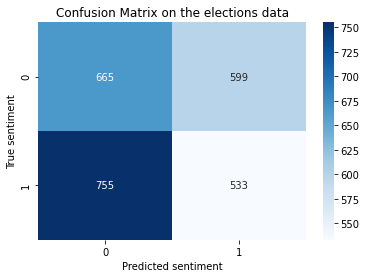

In [120]:
# Display the confusion matrix
cm = confusion_matrix(y_elections, y_predicted)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('True sentiment') 
ax.set_title('Confusion Matrix on the elections data')

Hyperparameter tuning did not result in big difference in the accuracy. It only went from 0.46 to 0.47. The model did not predict well on the elections data, and there was a big discrepancy between the predicted vs. true sentiment. The model incorrectly predicted 755 negative sentiments when they should have been positive, and 599 positive sentiments when they should have been negative.

### Visualizing sentiment prediction results and true sentiment for each of the two parties

Using the Logistic Regression model which performed the best, I visualized the sentiment prediction results and the true sentiment for each of the two parties.

In [121]:
def determine_political_affiliation(df):
    
    # Relevant words in the tweets that identify to certain political parties or candidates
    republican = '.*republican.*|.*republicans.*|.*donald trump.*|.*donaldtrump.*|.*donald.*|.*trump.*|.*republican party.*' 
    democratic = '.*democratic.*|.*democrats.*|.*joe biden.*|.*joebiden.*|.*joe.*|.*biden.*|.*democratic party.*' 
    
    # Create three new columns: Republican, Democratic, and Others
    df['Republican'] = ''
    df['Democratic'] = ''
    df['Others'] = ''
    
    for i in df.index:
        if re.match (republican, df['cleaned_tweet'][i]) :
            df["Republican"][i] = 'Yes'
                
        if re.match (democratic, df['cleaned_tweet'][i]) :
            df["Democratic"][i] = 'Yes'
            
        if df["Republican"][i] == '' and df["Democratic"][i] == '':
            df["Others"][i] = 'Yes'

determine_political_affiliation(df_elections)

# Separate the Republican tweets with Democratic tweets
republican_tweets = df_elections[df_elections.Republican == 'Yes']
democratic_tweets = df_elections[df_elections.Democratic == 'Yes']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [123]:
# Create TF-IDF features for both parties
vect_r = TfidfVectorizer(max_features=3000, ngram_range=(1, 3)) # set max features to be 3000 and have uni- to tri-grams
vect_r.fit(republican_tweets.cleaned_tweet)
X_r = vect_r.transform(republican_tweets.cleaned_tweet)

vect_d = TfidfVectorizer(max_features=3000, ngram_range=(1, 3)) # set max features to be 3000 and have uni- to tri-grams
vect_d.fit(democratic_tweets.cleaned_tweet)
X_d = vect_d.transform(democratic_tweets.cleaned_tweet)

In [124]:
# Transform back to a dataframe, assign column names
X_r = pd.DataFrame(X_r.toarray(), columns=vect_r.get_feature_names())
X_d = pd.DataFrame(X_d.toarray(), columns=vect_d.get_feature_names())

In [125]:
# convert to sparse matrix
X_r = csr_matrix(X_r)
X_d = csr_matrix(X_d)

In [126]:
# Define the target variable (y_elections)
y_r = republican_tweets.sentiment
y_d = democratic_tweets.sentiment

In [127]:
# Predict the labels
y_predicted_r = best_clf.predict(X_r)
y_predicted_d = best_clf.predict(X_d) 

# Print accuracy score on the elections data
print('Accuracy on Republican data: ', accuracy_score(y_r, y_predicted_r))

# Print accuracy score on the elections data
print('Accuracy on Democratic data: ', accuracy_score(y_d, y_predicted_d))

Accuracy on Republican data:  0.5071507150715071
Accuracy on Democratic data:  0.4437340153452685


In [128]:
# Display the shape of each parties
print(republican_tweets.shape)
print(democratic_tweets.shape)

(909, 7)
(782, 7)


Text(0.5, 1.0, 'Confusion Matrix on the Republican party')

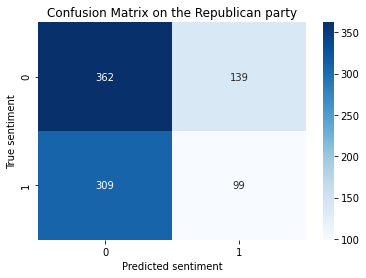

In [129]:
# Display the confusion matrix for Republican
cm_R = confusion_matrix(y_r, y_predicted_r)
ax = plt.subplot()
sns.heatmap(cm_R, annot=True, ax=ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('True sentiment') 
ax.set_title('Confusion Matrix on the Republican party')

For the Republican data, there were 139 false positives and 309 false negatives.

Text(0.5, 1.0, 'Confusion Matrix on the Democratic party')

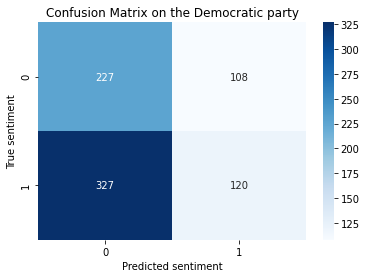

In [130]:
# Display the confusion matrix for Democratic
cm_D = confusion_matrix(y_d, y_predicted_d)
ax = plt.subplot()
sns.heatmap(cm_D, annot=True, ax=ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('True sentiment') 
ax.set_title('Confusion Matrix on the Democratic party')

For the Democratic data, there were 327 false positives and 108 false negatives.

Accuracy was lower for the Democratic data than Republican data. The confusion matrix illustrated that the model had a tendency to predict more towards negative sentiment. Lower accuracy on the elections data compared to the generic data was expected because the model was trained based on the generic tweets. Since the topics from the elections and generic tweets were different, logically it makes sense that the generic tweets data cannot generalize very well to the elections data. Therefore, NLP analytics based on tweets may not be useful for political parties during election campaigns if the tweets are generic. However, it could potentially be useful if the tweets are about elections or political party. For example, training data based on historical tweets about previous elections may give better predictions since it may generalize better to the 2020 elections data.

### Extracting only the negative sentiment US election tweets

Subsequently, I have extracted only the data with the negative sentiments, created BoW features, and split this data into training and testing (70/30 repectively). I have selected Logistic Regression, Decision Tree, and XGBoost algorithems to tune the hyperparameters, train on these algorithms, and predict reason for negative sentiments.

In [131]:
# Show the distribution of sentiments
df_elections.sentiment.value_counts()

1    1288
0    1264
Name: sentiment, dtype: int64

The sample size in each class are fairly balanced.

In [132]:
# Extract only the rows with negative sentiments
df_negative = df_elections[df_elections.sentiment == 0]

In [133]:
# Only keep the relevant columns
df_negative = df_negative[['negative_reason', 'cleaned_tweet', 'Republican', 'Democratic', 'Others']]

In [ ]:
# Display the types of negative reasons
df_negative.negative_reason.value_counts()

covid19           405
crime             222
corruption        220
discrimination    215
others            202
Name: negative_reason, dtype: int64

There are 5 different negative reasons. Covid-19 is the main reason for negative sentiment.

### Splitting the negative elections tweets into training data (70%) and test data (30%)

In [135]:
# Build the BoW vectorizer
vect = CountVectorizer(max_features=3000, ngram_range=(1, 3))
vect.fit(df_negative.cleaned_tweet)
X = vect.transform(df_negative.cleaned_tweet)

# Create a DataFrame
X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

# convert to sparse matrix
X = csr_matrix(X)

In [136]:
# Split the tweets randomly into 70% training and 30% test data.
y = df_negative.negative_reason #target variable

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Tuning hyperparameters and training on three classification algorithms

I have selected Logistic Regression, Decision Tree, and XGBoost classifiers to predict the reason for negative tweets

#### 1) Logistic Regression

In [137]:
# Create a model
logModel = LogisticRegression(max_iter=1000000)

In [138]:
# Define parameter range
param_grid = {'penalty' : ['l2'], 'C' : [0.001, 0.1, 10], 'solver' : ['liblinear', 'saga']}

# perfom grid search CV
clf_lr = GridSearchCV(logModel, param_grid=param_grid, cv=3, verbose=True, n_jobs = -1)

best_clf_lr = clf_lr.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.6s finished


In [139]:
# Get best estimators
best_clf_lr.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [140]:
# Using the best parameters obtained, determine the accuracy
best_clf_lr =  LogisticRegression(C=0.01, penalty='l2', solver='saga', max_iter=1000000)
best_clf_lr.fit(X_train, y_train)

# Predict the labels
y_predicted_lr = best_clf_lr.predict(X_test)

# Print accuracy score on the elections data
print('Logistic Regression accuracy: ', accuracy_score(y_test, y_predicted_lr))

# print classification report 
print(classification_report(y_test, y_predicted_lr))

Logistic Regression accuracy:  0.3
                precision    recall  f1-score   support

    corruption       0.00      0.00      0.00        66
       covid19       0.29      1.00      0.45       107
         crime       0.00      0.00      0.00        74
discrimination       1.00      0.11      0.19        66
        others       0.00      0.00      0.00        67

      accuracy                           0.30       380
     macro avg       0.26      0.22      0.13       380
  weighted avg       0.25      0.30      0.16       380



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 2) Decision Tree

In [141]:
# Create a model
DT = DecisionTreeClassifier()

In [142]:
# defining parameter range 
param_grid = {'ccp_alpha':[0.001, 0.015, 0.1], 'criterion':['gini', 'entropy'], 'max_depth':[2,4,10]}  

# Perform Grid Search CV
clf_dt = GridSearchCV(DT, param_grid=param_grid, cv=3, verbose = True, n_jobs = -1) 
  
# fitting the model for grid search 
best_clf_dt = clf_dt.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.3s finished


In [143]:
# Get best estimators
best_clf_dt.best_params_

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 4}

In [144]:
# Using the best parameters obtained, determine the accuracy
best_clf_dt =  DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=4)
best_clf_dt.fit(X_train, y_train)

# Predict the labels
y_predicted_dt = best_clf_dt.predict(X_test) 

# Print accuracy score on the elections data
print('Decision Tree accuracy: ', accuracy_score(y_test, y_predicted_dt))

# print classification report 
print(classification_report(y_test, y_predicted_dt))

Decision Tree accuracy:  0.30526315789473685
                precision    recall  f1-score   support

    corruption       0.00      0.00      0.00        66
       covid19       0.29      0.98      0.45       107
         crime       0.33      0.01      0.03        74
discrimination       0.88      0.11      0.19        66
        others       0.50      0.04      0.08        67

      accuracy                           0.31       380
     macro avg       0.40      0.23      0.15       380
  weighted avg       0.39      0.31      0.18       380



#### 3) XGBoost

In [145]:
# Create a model
XGB = xgboost.XGBClassifier()

In [146]:
# defining parameter range 
param_grid = {"learning_rate": [0.05, 0.15, 0.30], "max_depth": [3,5,15], "min_child_weight": [1, 3], "gamma": [0.0, 0.4],
              "colsample_bytree" : [0.3, 0.7]}

# Perform Grid Search CV
clf_XGB = GridSearchCV(XGB, param_grid=param_grid, cv=3, verbose = True, n_jobs = -1) 
  
# fitting the model for grid search 
best_clf_XGB = clf_XGB.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  3.5min finished


In [147]:
# Get best estimators
best_clf_XGB.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.4,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1}

In [148]:
# Using the best parameters obtained, determine the accuracy
best_clf_XGB = xgboost.XGBClassifier(colsample_bytree=0.3, gamma=0.4, learning_rate=0.05, max_depth=5, min_child_weight=1)
best_clf_XGB.fit(X_train, y_train)

# Predict the labels
y_predicted_XGB = best_clf_XGB.predict(X_test) 

# Print accuracy score on the elections data
print('XGBoost accuracy: ', accuracy_score(y_test, y_predicted_XGB))

# print classification report 
print(classification_report(y_test, y_predicted_XGB))

XGBoost accuracy:  0.3236842105263158
                precision    recall  f1-score   support

    corruption       0.42      0.08      0.13        66
       covid19       0.31      0.92      0.46       107
         crime       0.38      0.07      0.11        74
discrimination       0.47      0.11      0.17        66
        others       0.42      0.12      0.19        67

      accuracy                           0.32       380
     macro avg       0.40      0.26      0.21       380
  weighted avg       0.39      0.32      0.24       380



All three models had a significantly low accuracy score. The best out of the three was XGBoost, which had a score of 0.32. Therefore, this algorithm was selected to make predictions.

### Predicted reason vs. True reason for negative sentiment tweets

In [149]:
# Show the value counts of different negative reasons.
y_test.value_counts()

covid19           107
crime              74
others             67
discrimination     66
corruption         66
Name: negative_reason, dtype: int64

Text(0.5, 1.0, 'Confusion Matrix on the reason for negative sentiment tweets')

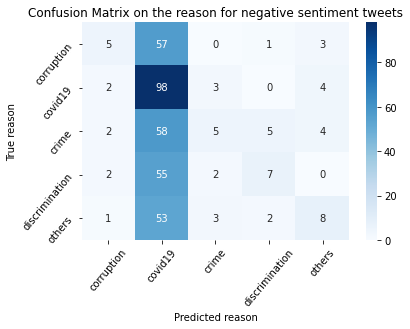

In [150]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_predicted_XGB)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

# labels, title and ticks
labels = ['corruption', 'covid19', 'crime', 'discrimination', 'others']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted reason')
ax.set_ylabel('True reason') 
plt.xticks(rotation=50)
plt.yticks(rotation=50)
ax.set_title('Confusion Matrix on the reason for negative sentiment tweets')

As illustrated in the above confusion matrix, it is evident that the model is classifying most of the tweets as Covid-19. This inaccurate predictions may be due to the fact that Covid-19 is the most prominant class compared to the other classes.

## 5) Results

### Results of Analysis and discussion

After training and testing the generic tweets data, I obtained the best accuracy of 0.954 for Logistic Regression on Bag-of-Words method. Evaluating this model on the 2020 US Elections data resulted in significantly lower accuracy (about ~0.5). I have also tried to predict the reasons for negative sentiment for both parties. The best model was XGBoost, although it had an accuracy of 0.32. Based on the outputs of my models, it can be concluded that public opinion on Twitter may not help gain insight about the US political landscape in 2020. As the accuracy scores and confusion matrix revealed, the model is very biased toward one specific class. For the first model, it was predicting many elections tweets as negative. For the second model, it was predicting majority of the reasons for negative sentiment as Covid-19. Perhaps the reasoning behind why the predictions are biased toward one class could be due to imbalanced classes. As Covid-19 was the majority, the model was trying to predict almost every tweets as Covid-19 (i.e. 321 out of 380 tweets, or 84.5% were being classified as Covid-19). In the case of elections tweets, Republican party had majority of negative tweets whereas Democratic party had slightly more positive tweets. As the model had a tendency to favour classifying the tweets as negative, this may explain why Republicans had higher accuracy (0.51) compared to Democrats (0.44). Even with hyperparameter tuning, the model performance did not improve much. Since including large range of hyperparameters had caused extremely slow runtime for me, I had to limit the ranges so that cells can run faster. However, perhaps one way to improve the accuracy of my models could be to include more range of parameters when performing hyperparameter tuning. Another method could be to use Artificial Neural networks or LSTM models because they tend of work well with NLP-based classification data. If my computer had better computing resources, I would try ANN and LSTM to improve the performance. <br>
Another suggestion would be to add an extra column that provides the values of sentiments that range from negative 5 to positive 5, where the larger the number, the more intense the sentiment. For example, the word "good" may have value of 3 while "great" may have value of 5. From the corpus that contains sentiment values for each words, we could look at each word in the tweets and determine the intensity of the words. Since having binary (negative or positive) may not be useful when it comes to neutral tweets, this technique could be useful in predicting more accurately and precisely tweets that reflect the true sentiments.

### How each party is viewed in the public eye based on the sentiment value

Word clouds may potentially give us some insights into how each party is viewed in the public eye since they may reveal the essential topics. I have created a word cloud for each parties, removing the most common or obvious words, such as 'Trump', 'Biden', 'election', etc.

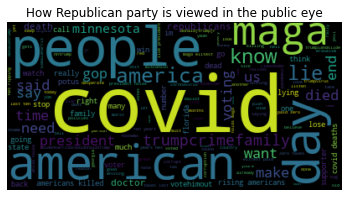

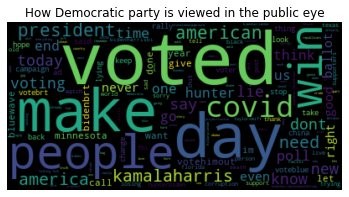

In [ ]:
# combine all the tweets into one string
combined_r = ''
for tweet in republican_tweets['cleaned_tweet']:
    combined_r = combined_r + '' + tweet
combined_d = ''
for tweet in democratic_tweets['cleaned_tweet']:
    combined_d = combined_d + '' + tweet

# Common/obvious words such as 'trump' and 'election' they will not be informative so remove them from the word cloud.
stop_words = set(STOPWORDS)
stop_words.update(['brt', 'trump', 'realdonaldtrump', 'donald trump', 'donald', 'republican', 'biden', 'joebiden', 'vote', 'election', 'bidenharris', 'democrat', 'bidenharrisbrt',
                   'democrats', 'trumps', 'joe'])

# Generate the word cloud. 
cloud_republican = WordCloud(stopwords=stop_words).generate(combined_r)
cloud_democratic = WordCloud(stopwords=stop_words).generate(combined_d)

# Display the word cloud
plt.imshow(cloud_republican, interpolation='bilinear')
plt.axis('off')
plt.title('How Republican party is viewed in the public eye')
plt.show()

plt.imshow(cloud_democratic, interpolation='bilinear')
plt.axis('off')
plt.title('How Democratic party is viewed in the public eye')
plt.show()

For the Republican party, the word that stand out the most is "Covid". Words such as "American", "people", and "MAGA" (which stands for "Make America Great Again") is also noticeable, which may be neutral or perhaps positive. I also see "lie", which suggests a negative sentiment. For the Democratic party, relevant words seem to be "voted" and "win", implying a positive sentiment.